In [8]:
# import sys
# sys.path.insert(0, 'C:/Users/chris/Documents/GitHub/AzureFunctions/AzureFunctions')
# import datetime
# import logging
# import time
# from datetime import date
# import os
# from io import BytesIO
# import pandas as pd
# import yfinance as yf


# from azure.storage.filedatalake import DataLakeServiceClient
# import azure.functions as func
from shared_code import utils

# pd.set_option('display.max_columns', None)

In [2]:
import queue
import pandas as pd
import logging
import requests as r
import yfinance as yf

from lxml import html
from io import BytesIO
from io import StringIO
from datetime import date
from azure.storage.blob import BlobServiceClient
from azure.storage.filedatalake import DataLakeServiceClient
from azure.identity import DefaultAzureCredential
from azure.keyvault.secrets import SecretClient
from azure.storage.queue import (
        QueueClient,
        BinaryBase64EncodePolicy,
        BinaryBase64DecodePolicy
)

class AzureUtils:
    def __init__(self, vault_url=None, storageaccount=None):
        self.vault_url = "https://kv-yahoo-prod-001.vault.azure.net/"

    def initialize_storage_account_ad(self, storage_account_secret, blob):
        try:  
            global blob_service_client_instance
            blob_service_client_instance = BlobServiceClient(
                account_url = "{}://{}.blob.core.windows.net".format("https", blob), 
                credential = storage_account_secret
                )
        except Exception as e:
            logging.error(f"Could not create blob service client: {e}")
            
    def initialize_data_lake(self, storage_account_name, storage_account_secret):
        try:  
            global datalake_service_client
            datalake_service_client = DataLakeServiceClient(
                account_url = "{}://{}.dfs.core.windows.net".format("https", storage_account_name), 
                credential = storage_account_secret
                )
        except Exception as e:
            logging.error(f"Could not create data lake service client: {e}")

    def initialize_queue_client(self, accountUrl, queueName):
        try:  
            global queue_client_instance
            queue_client_instance = QueueClient.from_connection_string(
                conn_str = accountUrl, 
                queue_name = queueName,
                message_encode_policy = BinaryBase64EncodePolicy(),
                message_decode_policy = BinaryBase64DecodePolicy()
                )
            logging.info(f"Connected to queue {queueName} successfully")
        except Exception as e:
            logging.error(f"Error connecting to queue {queueName}: {e}")

    def send_queue_message(self, message):
        try:
            queue_client_instance.send_message(message.encode("utf-8"))
            logging.info(f"Queued message {message} successfully")
        except Exception as e:
            logging.error(f"Error queueing message {message}: {e}")
   
    def upload_blob(self, data, container, blob_name):
        blob_client_instance = blob_service_client_instance.get_blob_client(container, blob_name, snapshot = None)
        try:
            blob_client_instance.upload_blob(data, overwrite = True, encoding = "utf-8", length=len(data))
            logging.info(f"Created blob {blob_name} successfully")
        except Exception as e:
            logging.error(f"Error creating blob {blob_name}: {e}")
            
    def write_dataframe_to_datalake(self, df, dir_name, filename):
        file_system_client = datalake_service_client.get_file_system_client(file_system = "gold")
        directory_client = file_system_client.get_directory_client(dir_name)
        file_client = directory_client.create_file(f'{filename}_{date.today()}.Parquet')
        
        df_parquet = df.to_parquet()
        file_client.append_data(data = df_parquet, offset = 0, length = len(df_parquet))
        file_client.flush_data(len(df_parquet))
        return True
    
    def download_parquet_blob(self, container, blob_name):
        blob_client_instance = blob_service_client_instance.get_blob_client(container, blob_name, snapshot = None)
        try:
            with BytesIO() as input_blob:
                blob_client_instance.download_blob().download_to_stream(input_blob)
                input_blob.seek(0)
                df = pd.read_parquet(input_blob)
            logging.info(f"Downloaded blob {blob_name} successfully")    
        except Exception as e:
            logging.error(f"Error downloadning blob {blob_name}: {e}")
        return df
    
    def download_csv_blob(self, container, blob_name):
        blob_client_instance = blob_service_client_instance.get_blob_client(container, blob_name, snapshot = None)
        try:
            with BytesIO() as input_blob:
                blob_client_instance.download_blob().download_to_stream(input_blob)
                input_blob.seek(0)
                df = pd.read_csv(input_blob)
            logging.info(f"Downloaded blob {blob_name} successfully")    
        except Exception as e:
            logging.error(f"Error downloadning blob {blob_name}: {e}")
        return df
    
    def ingest_bronze_data(self, directory):
        blob_list = self.list_blobs("bronze", directory)
        df = pd.concat([self.download_parquet_blob("bronze", blob.name) for blob in blob_list], ignore_index = True)
        return df
    
    def ingest_silver_data(self, directory):
        blob_list = self.list_blobs("silver", directory)
        df = pd.concat([self.download_parquet_blob("silver", blob.name) for blob in blob_list], ignore_index = True)
        return df
    
    def list_blobs(self, container, blob_name_starts_with):
        try:
            container_client_instance = blob_service_client_instance.get_container_client(container)
            blob_list = container_client_instance.list_blobs(blob_name_starts_with)
            logging.info(f"Retreived list of blobs that starts with name {blob_name_starts_with} from container {container}")
        except Exception as e:
            logging.error(f"Error retreiving list of blobs in container {container} with blob name starting with {blob_name_starts_with}: {e}")
        return blob_list
            
    def initialize_key_vault(self):
        credential = DefaultAzureCredential(exclude_interactive_browser_credential=False, additionally_allowed_tenants=['*'])
        secret_client = SecretClient(vault_url = self.vault_url, credential=credential)
        return secret_client

    def get_key_vault_secret(self, secret_client, secret_name):
        return secret_client.get_secret(secret_name)

class yahooUtils:
    def __init__(self):
        self.nasdaq_base_url = "http://www.nasdaqomxnordic.com" 
        self.nasdaq_full_url = self.nasdaq_base_url + "/shares/listed-companies/stockholm"

    def scrape_nasdaq_companies(self):
        headers = {"User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"}
        page = r.get(self.nasdaq_full_url, headers = headers)
        tree = html.fromstring(page.content)
        page.close
        tree.make_links_absolute(self.nasdaq_base_url)
        trs = tree.xpath('//tbody//tr')
        df_companies = pd.DataFrame(
                [[j.text_content() for j in i.getchildren()[:-1]] for i in trs],
                columns = ['name','symbol','currency','isin','sector','icb']
                )
        # here we create the ticker names for the queries to Yahoo Finance
        df_companies['tickers'] = ["-".join(i.split(" "))+".ST" for i in df_companies['symbol'].values]
        return df_companies

    def get_ticker_financials(self, ticker):
        try:
            ticker_object = yf.Ticker(ticker)
            temp = pd.DataFrame.from_dict(ticker_object.info, orient = "index")
            temp.reset_index(inplace = True)
            temp.columns = ["Attribute", "Recent"]
            temp["Ticker"] = ticker
            return temp
        except Exception as e:
            print(e)

#Structure created by Sarah Floris
class DataCleaning:
    def __init__(self):
        pass
    
    def pivot_fundamentals_dataframe(self, df, selected_index = ["Ticker", "ObservationDate"], selected_column = "Attribute", selected_value = "Recent"):
        try:
            return df.pivot(index = selected_index, columns = selected_column, values = selected_value).reset_index()
        except Exception as e:
            logging.error(f"Couldn't pivot the dataframe: {e}")
    
    def select_dataframe_columns(self, df, columns):
        try:
            return df[columns]
        except Exception as e:
            logging.error(f"Could not select columns {columns}: {e}")
            
    def set_dtype_to_numeric(self, df, cols_to_exclude):
        try:
            df.loc[:, ~df.columns.isin(cols_to_exclude)] = df.loc[:, ~df.columns.isin(cols_to_exclude)].apply(pd.to_numeric, errors = 'coerce')
        except Exception as e:
            logging.error(f"Could not change data type to numeric for all columns except {cols_to_exclude}: {e}")
        return df
    
    def change_timestamp_to_datetime(self, df, column_name):
        try:
            df[column_name] = df[column_name].apply(lambda x: pd.to_datetime(x, unit = 's'))
        except Exception as e:
            logging.error(f"Could not change timestamp to datetime for column {column_name}: {e}")
        return df
    
    def change_timestamp_format(self, df, column_name, date_format = '%Y-%m-%d'):
        df[column_name] = df[column_name].apply(lambda x: pd.to_datetime(x, format = date_format))
        return df
    
class FeatureEngineering:
    def __init__(self):
        pass
    
class DataFactory:
    def get_formatter(self, format):
        if format == 'Cleaning':
            return DataCleaning()
        elif format == 'Features':
            return FeatureEngineering()
        else:
            ValueError(format)

In [3]:
azure_utils = AzureUtils()
secret_client = azure_utils.initialize_key_vault()

sa_secret = azure_utils.get_key_vault_secret(secret_client, 'sa-secret')
sa_name = azure_utils.get_key_vault_secret(secret_client, 'sa-name')

azure_utils.initialize_storage_account_ad(sa_secret.value, sa_name.value)
azure_utils.initialize_data_lake(sa_name.value, sa_secret.value)

In [4]:
selected_cols = [
    'Ticker',
    'ObservationDate',
    'mostRecentQuarter',
    'fullTimeEmployees',
    'ebitdaMargins',
    'profitMargins',
    'grossMargins',
    'operatingCashflow',
    'revenueGrowth',
    'operatingMargins',
    'ebitda',
    'targetLowPrice',
    'recommendationKey',
    'grossProfits',
    'freeCashflow',
    'targetMedianPrice',
    'currentPrice',
    'earningsGrowth',
    'currentRatio',
    'returnOnAssets',
    'numberOfAnalystOpinions',
    'targetMeanPrice',
    'debtToEquity',
    'returnOnEquity',
    'targetHighPrice',
    'totalCash',
    'totalDebt',
    'totalRevenue',
    'recommendationMean',
    'enterpriseToRevenue',
    'enterpriseToEbitda',
    '52WeekChange',
    'morningStarRiskRating',
    'forwardEps',
    'sharesOutstanding',
    'heldPercentInstitutions',
    'trailingEps',
    'lastDividendValue',
    'priceToBook',
    'heldPercentInsiders',
    'beta',
    'enterpriseValue',
    'priceToSalesTrailing12Months',
    'forwardPE',
    'trailingPE',
    'marketCap'
]
cols_to_exclude = ['Ticker', 'ObservationDate', 'recommendationKey', 'mostRecentQuarter']

dataCleaning_utils = DataCleaning()

df_cleaning = (
    azure_utils.ingest_bronze_data(f"fundamentals/")
    .pipe(dataCleaning_utils.pivot_fundamentals_dataframe)
    .pipe(dataCleaning_utils.select_dataframe_columns, selected_cols)
    .pipe(dataCleaning_utils.set_dtype_to_numeric, cols_to_exclude)
    .pipe(dataCleaning_utils.change_timestamp_to_datetime, "mostRecentQuarter")
    .pipe(dataCleaning_utils.change_timestamp_format, "ObservationDate")
)

df_cleaning.head()

Attribute,Ticker,ObservationDate,mostRecentQuarter,fullTimeEmployees,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,...,trailingEps,lastDividendValue,priceToBook,heldPercentInsiders,beta,enterpriseValue,priceToSalesTrailing12Months,forwardPE,trailingPE,marketCap
0,8TRA.ST,2022-10-26,2022-06-30,99865.0,0.09657,0.02293,0.16506,-643000000.0,0.336,0.02887,...,17.65,0.5,4.986207,0.89722,1.760954,89272287232.0,2.066836,NaN,8.192636,72300003328.0
1,8TRA.ST,2022-10-27,2022-06-30,99865.0,0.09657,0.02293,0.16506,-643000000.0,0.336,0.02887,...,17.65,0.5,4.97931,0.89722,1.760954,89272287232.0,2.063978,NaN,8.181303,72199995392.0
2,8TRA.ST,2022-10-28,2022-06-30,99865.0,0.09657,0.02293,0.16506,-643000000.0,0.336,0.02887,...,17.65,0.5,5.127586,0.89722,1.760954,89272287232.0,2.12544,NaN,8.42493,74350002176.0
3,8TRA.ST,2022-10-29,2022-06-30,99865.0,0.09657,0.02293,0.16506,-643000000.0,0.336,0.02887,...,17.52,0.5,4.775862,0.89722,1.760954,93103955968.0,1.979646,NaN,7.905251,69249998848.0
4,8TRA.ST,2022-10-30,2022-09-30,97235.0,0.11473,0.01197,0.16392,-338000000.0,0.312,0.05081,...,17.52,0.5,4.665184,0.89722,NaN,88297455616.0,1.961348,NaN,7.905251,73540730880.0


In [10]:
parquet_file = df_cleaning.to_parquet(index = False)
azure_utils.upload_blob(parquet_file, f"silver/fundamentals", "fundamentals.parquet")

In [11]:
dataCleaning_utils = utils.DataCleaning()

df_fundamentals = (
    azure_utils.ingest_silver_data(f"fundamentals/fundamentals")
)

df_fundamentals

,Ticker,ObservationDate,mostRecentQuarter,fullTimeEmployees,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,...,trailingEps,lastDividendValue,priceToBook,heldPercentInsiders,beta,enterpriseValue,priceToSalesTrailing12Months,forwardPE,trailingPE,marketCap
0,8TRA.ST,2022-10-26,2022-06-30,99865.0,0.09657,0.02293,0.16506,-643000000.0,0.336,0.02887,...,17.65,0.5,4.986207,0.89722,1.760954,8.927229e+10,2.066836,NaN,8.192636,7.230000e+10
1,8TRA.ST,2022-10-27,2022-06-30,99865.0,0.09657,0.02293,0.16506,-643000000.0,0.336,0.02887,...,17.65,0.5,4.979310,0.89722,1.760954,8.927229e+10,2.063978,NaN,8.181303,7.220000e+10
2,8TRA.ST,2022-10-28,2022-06-30,99865.0,0.09657,0.02293,0.16506,-643000000.0,0.336,0.02887,...,17.65,0.5,5.127586,0.89722,1.760954,8.927229e+10,2.125440,NaN,8.424930,7.435000e+10
3,8TRA.ST,2022-10-29,2022-06-30,99865.0,0.09657,0.02293,0.16506,-643000000.0,0.336,0.02887,...,17.52,0.5,4.775862,0.89722,1.760954,9.310396e+10,1.979646,NaN,7.905251,6.925000e+10
4,8TRA.ST,2022-10-30,2022-09-30,97235.0,0.11473,0.01197,0.16392,-338000000.0,0.312,0.05081,...,17.52,0.5,4.665184,0.89722,NaN,8.829746e+10,1.961348,NaN,7.905251,7.354073e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38664,XVIVO.ST,2023-05-23,2023-03-31,137.0,0.06487,0.06009,0.72650,24776000.0,0.518,0.04196,...,0.93,NaN,6.195749,0.12257,1.979497,8.785183e+09,19.351168,67.376680,323.118300,8.964486e+09
38665,XVIVO.ST,2023-05-24,2023-03-31,137.0,0.06487,0.06009,0.72650,24776000.0,0.518,0.04196,...,0.93,NaN,5.999877,0.12257,1.979497,8.785183e+09,18.739399,65.246635,312.903230,8.681083e+09
38666,XVIVO.ST,2023-05-25,2023-03-31,137.0,0.06487,0.06009,0.72650,24776000.0,0.518,0.04196,...,0.90,NaN,5.855549,0.12257,1.979497,8.501779e+09,18.288624,63.677128,315.555570,8.472260e+09
38667,XVIVO.ST,2023-05-26,2023-03-31,137.0,0.06487,0.06009,0.72650,24776000.0,0.518,0.04196,...,0.90,NaN,5.814313,0.12257,1.979497,8.501779e+09,18.159830,63.228700,313.333340,8.412596e+09


In [21]:
parquet_file = df_fundamentals.to_parquet(index = False)
azure_utils.upload_blob(parquet_file, f"gold/fundamentals", "fact_fundamentals.parquet")

In [22]:
fact_fundamentals = azure_utils.download_parquet_blob(f"gold/fundamentals", f"fact_fundamentals.parquet")
fact_fundamentals.head()

,Ticker,ObservationDate,mostRecentQuarter,fullTimeEmployees,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,...,trailingEps,lastDividendValue,priceToBook,heldPercentInsiders,beta,enterpriseValue,priceToSalesTrailing12Months,forwardPE,trailingPE,marketCap
0,8TRA.ST,2022-10-26,2022-06-30,99865.0,0.09657,0.02293,0.16506,-643000000.0,0.336,0.02887,...,17.65,0.5,4.986207,0.89722,1.760954,8.927229e+10,2.066836,NaN,8.192636,7.230000e+10
1,8TRA.ST,2022-10-27,2022-06-30,99865.0,0.09657,0.02293,0.16506,-643000000.0,0.336,0.02887,...,17.65,0.5,4.979310,0.89722,1.760954,8.927229e+10,2.063978,NaN,8.181303,7.220000e+10
2,8TRA.ST,2022-10-28,2022-06-30,99865.0,0.09657,0.02293,0.16506,-643000000.0,0.336,0.02887,...,17.65,0.5,5.127586,0.89722,1.760954,8.927229e+10,2.125440,NaN,8.424930,7.435000e+10
3,8TRA.ST,2022-10-29,2022-06-30,99865.0,0.09657,0.02293,0.16506,-643000000.0,0.336,0.02887,...,17.52,0.5,4.775862,0.89722,1.760954,9.310396e+10,1.979646,NaN,7.905251,6.925000e+10
4,8TRA.ST,2022-10-30,2022-09-30,97235.0,0.11473,0.01197,0.16392,-338000000.0,0.312,0.05081,...,17.52,0.5,4.665184,0.89722,NaN,8.829746e+10,1.961348,NaN,7.905251,7.354073e+10


In [23]:
fact_fundamentals = fact_fundamentals.set_index(["Ticker", "ObservationDate"])
df_fundamentals = df_fundamentals.set_index(["Ticker", "ObservationDate"])
fact_fundamentals = pd.concat([df_fundamentals[~df_fundamentals.index.isin(fact_fundamentals.index)], fact_fundamentals])
fact_fundamentals

mostRecentQuarter  fullTimeEmployees  ebitdaMargins  \
Ticker   ObservationDate                                                       
8TRA.ST  2022-10-26             2022-06-30            99865.0        0.09657   
         2022-10-27             2022-06-30            99865.0        0.09657   
         2022-10-28             2022-06-30            99865.0        0.09657   
         2022-10-29             2022-06-30            99865.0        0.09657   
         2022-10-30             2022-09-30            97235.0        0.11473   
...                                    ...                ...            ...   
XVIVO.ST 2023-05-23             2023-03-31              137.0        0.06487   
         2023-05-24             2023-03-31              137.0        0.06487   
         2023-05-25             2023-03-31              137.0        0.06487   
         2023-05-26             2023-03-31              137.0        0.06487   
         2023-05-27             2023-03-31              137.0        0.06487   

                          profitMargins  grossMargins  operatingCashflow  \
Ticker   ObservationDate                                                   
8TRA.ST  2022-10-26             0.02293       0.16506       -643000000.0   
         2022-10-27             0.02293       0.16506       -643000000.0   
         2022-10-28             0.02293       0.16506       -643000000.0   
         2022-10-29             0.02293       0.16506       -643000000.0   
         2022-10-30             0.01197       0.16392       -338000000.0   
...                                 ...           ...                ...   
XVIVO.ST 2023-05-23             0.06009       0.72650         24776000.0   
         2023-05-24             0.06009       0.72650         24776000.0   
         2023-05-25             0.06009       0.72650         24776000.0   
         2023-05-26             0.06009       0.72650         24776000.0   
         2023-05-27             0.06009       0.72650         24776000.0   

                          revenueGrowth  operatingMargins        ebitda  \
Ticker   ObservationDate                                                  
8TRA.ST  2022-10-26               0.336           0.02887  3.378000e+09   
         2022-10-27               0.336           0.02887  3.378000e+09   
         2022-10-28               0.336           0.02887  3.378000e+09   
         2022-10-29               0.336           0.02887  3.378000e+09   
         2022-10-30               0.312           0.05081  4.302000e+09   
...                                 ...               ...           ...   
XVIVO.ST 2023-05-23               0.518           0.04196  3.005300e+07   
         2023-05-24               0.518           0.04196  3.005300e+07   
         2023-05-25               0.518           0.04196  3.005300e+07   
         2023-05-26               0.518           0.04196  3.005300e+07   
         2023-05-27               0.518           0.04196  3.005300e+07   

                          targetLowPrice  ... trailingEps  lastDividendValue  \
Ticker   ObservationDate                  ...                                  
8TRA.ST  2022-10-26                  NaN  ...       17.65                0.5   
         2022-10-27                  NaN  ...       17.65                0.5   
         2022-10-28                  NaN  ...       17.65                0.5   
         2022-10-29                  NaN  ...       17.52                0.5   
         2022-10-30                  NaN  ...       17.52                0.5   
...                                  ...  ...         ...                ...   
XVIVO.ST 2023-05-23                385.0  ...        0.93                NaN   
         2023-05-24                385.0  ...        0.93                NaN   
         2023-05-25                385.0  ...        0.90                NaN   
         2023-05-26                385.0  ...        0.90                NaN   
         2023-05-27                385.0  ...        0.90  

In [ ]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
pd.DataFrame({"Data Type" : dim_company.dtypes})

In [24]:
pd.DataFrame({"Missing Values )%)": df_fundamentals.isnull().sum()/len(df_fundamentals.index)*100})

,Missing Values )%)
mostRecentQuarter,22.255554
fullTimeEmployees,23.662365
ebitdaMargins,22.211591
profitMargins,22.211591
grossMargins,22.211591
operatingCashflow,25.757066
revenueGrowth,29.954227
operatingMargins,22.211591
ebitda,30.179213
targetLowPrice,46.210142


In [25]:
data1 = {
  "name": ["Sally", "Mary", "John"],
  "age": [50, 40, 30]
}

data2 = {
  "name": ["Sally", "Peter", "Micky"],
  "age": [77, 44, 22]
}

df1 = pd.DataFrame(data1).set_index("name")
df2 = pd.DataFrame(data2).set_index("name")

pd.concat([df1[~df1.index.isin(df2.index)], df2])

,age
name,
Mary,40
John,30
Sally,77
Peter,44
Micky,22


In [ ]:
df_company = df_company.set_index("Ticker")
dim_company = dim_company.set_index("Ticker")
pd.concat([dim_company[dim_company.index.isin(df_company.index)], df_company])

In [ ]:
parquet_file = fact_fundamentals.to_parquet(index = None)
azure_utils.upload_blob(parquet_file, f"gold/company", "dim_company.parquet")

In [42]:
dim_company = azure_utils.download_parquet_blob("bronze/companies/nasdaqOmxStockholm", "companies.parquet")
dim_company = dim_company.rename(columns = {"tickers": "Ticker"})
parquet_file = dim_company.to_parquet(index = None)
azure_utils.upload_blob(parquet_file, f"gold/dimcompany", "dim_company.parquet")

In [43]:
dim_company

,name,symbol,currency,isin,sector,icb,Ticker
0,TRATON,8TRA,SEK,DE000TRAT0N7,Industrials,5020,8TRA.ST
1,AAK,AAK,SEK,SE0011337708,Consumer Goods,4510,AAK.ST
2,ABB Ltd,ABB,SEK,CH0012221716,Industrials,5020,ABB.ST
3,Addtech B,ADDT B,SEK,SE0014781795,Industrials,5020,ADDT-B.ST
4,AFRY,AFRY,SEK,SE0005999836,Industrials,5010,AFRY.ST
...,...,...,...,...,...,...,...
403,Transtema Group,TRANS,SEK,SE0006758587,Industrials,5020,TRANS.ST
404,Vicore Pharma Holding,VICO,SEK,SE0007577895,Health Care,2010,VICO.ST
405,Vivesto,VIVE,SEK,SE0000722365,Health Care,2010,VIVE.ST
406,Wise Group,WISE,SEK,SE0007277876,Industrials,5020,WISE.ST


In [34]:
fact_fundamentals = fact_fundamentals.reset_index()

In [36]:
selected_cols = [
    "Ticker",
    "ObservationDate",
    "mostRecentQuarter",
    "enterpriseToRevenue",
    "enterpriseToEbitda",
    "forwardEps",
    "trailingEps",
    "enterpriseValue",
    "forwardPE",
    "trailingPE",
    "marketCap"
]
fact_valuation = fact_fundamentals[selected_cols]
fact_valuation

,Ticker,ObservationDate,mostRecentQuarter,enterpriseToRevenue,enterpriseToEbitda,forwardEps,trailingEps,enterpriseValue,forwardPE,trailingPE,marketCap
0,8TRA.ST,2022-10-26,2022-06-30,2.552,26.428,NaN,17.65,8.927229e+10,NaN,8.192636,7.230000e+10
1,8TRA.ST,2022-10-27,2022-06-30,2.552,26.428,NaN,17.65,8.927229e+10,NaN,8.181303,7.220000e+10
2,8TRA.ST,2022-10-28,2022-06-30,2.552,26.428,NaN,17.65,8.927229e+10,NaN,8.424930,7.435000e+10
3,8TRA.ST,2022-10-29,2022-06-30,2.662,27.562,NaN,17.52,9.310396e+10,NaN,7.905251,6.925000e+10
4,8TRA.ST,2022-10-30,2022-09-30,2.355,20.525,NaN,17.52,8.829746e+10,NaN,7.905251,7.354073e+10
...,...,...,...,...,...,...,...,...,...,...,...
38664,XVIVO.ST,2023-05-23,2023-03-31,18.964,292.323,4.46,0.93,8.785183e+09,67.376680,323.118300,8.964486e+09
38665,XVIVO.ST,2023-05-24,2023-03-31,18.964,292.323,4.46,0.93,8.785183e+09,65.246635,312.903230,8.681083e+09
38666,XVIVO.ST,2023-05-25,2023-03-31,18.352,282.893,4.46,0.90,8.501779e+09,63.677128,315.555570,8.472260e+09
38667,XVIVO.ST,2023-05-26,2023-03-31,18.352,282.893,4.46,0.90,8.501779e+09,63.228700,313.333340,8.412596e+09


In [44]:
fact_valuation = fact_valuation.merge(dim_company, on = "Ticker", how = "inner")

In [46]:
fact_valuation = fact_valuation[["ObservationDate", "sector", "enterpriseToEbitda"]].groupby([pd.Grouper(key = "ObservationDate", axis = 0, freq = "D"), "sector"]).mean().reset_index()
fact_valuation

,ObservationDate,sector,enterpriseToEbitda
0,2022-10-26,Basic Materials,23.428792
1,2022-10-26,Consumer Goods,13.782375
2,2022-10-26,Consumer Services,58.014211
3,2022-10-26,Energy,25.534625
4,2022-10-26,Financials,-31.435333
...,...,...,...
1040,2023-05-27,Industrials,138.876462
1041,2023-05-27,Real Estate,301.947591
1042,2023-05-27,Technology,17.106118
1043,2023-05-27,Telecommunications,2.764846


<AxesSubplot: xlabel='ObservationDate'>

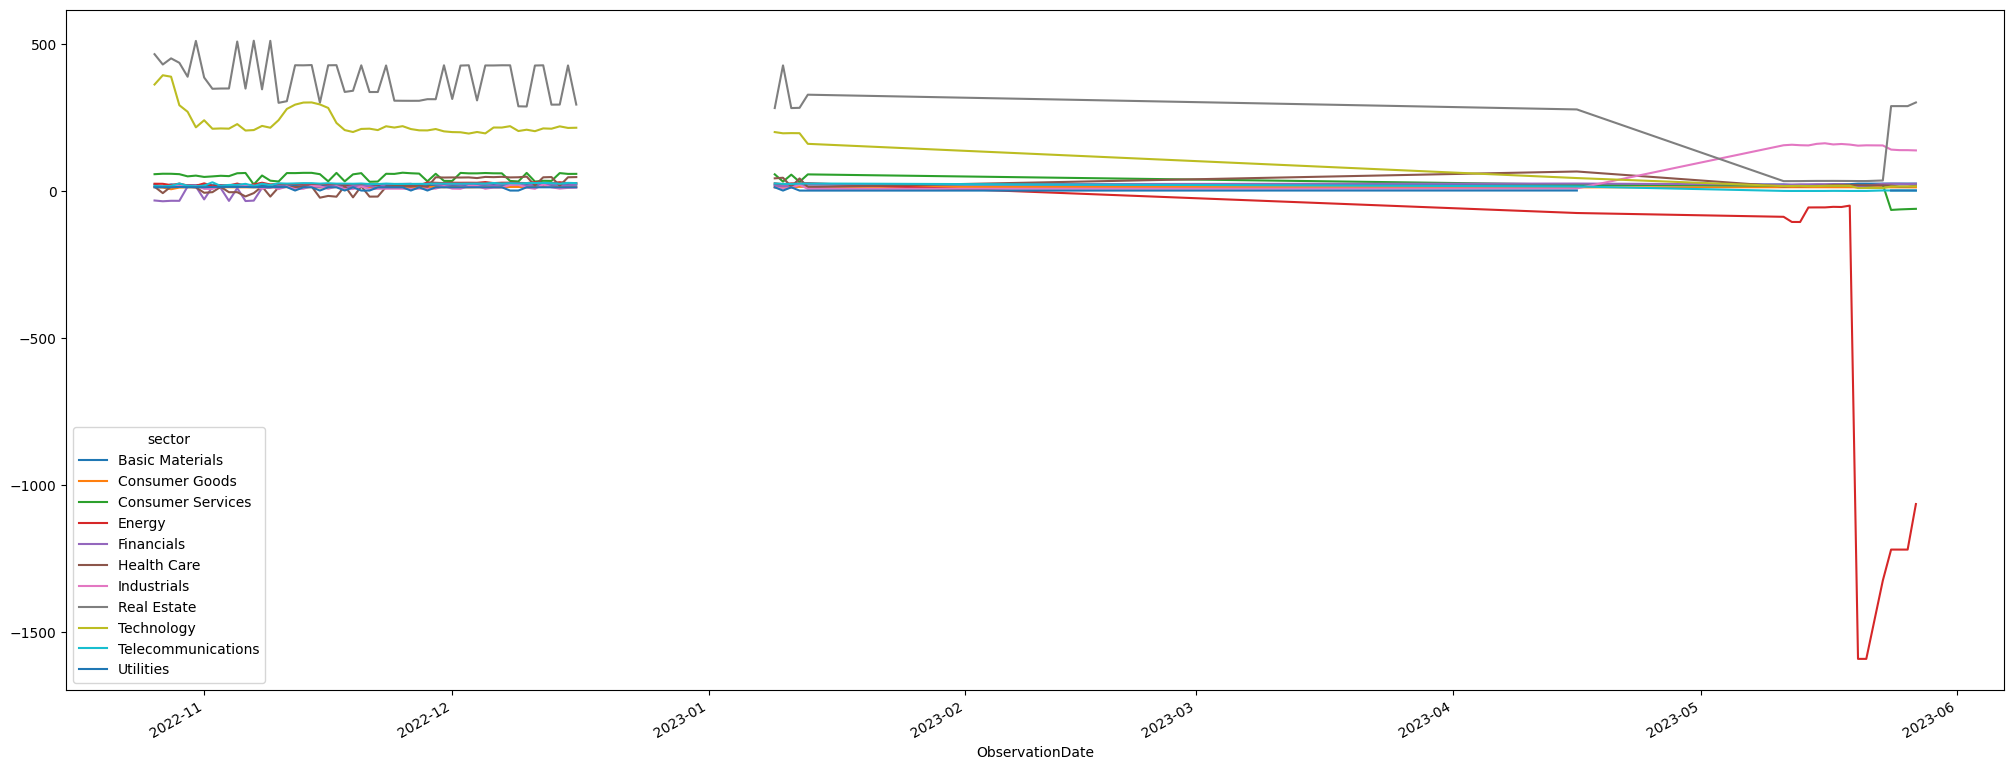

In [48]:
fact_valuation.pivot(index = "ObservationDate", columns = "sector", values = "enterpriseToEbitda").plot(kind = "line", figsize = (25, 10))

In [ ]:
fact_valuation